# Temporal Forecasting Using ML and DL Models

## Import the Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from tqdm import tqdm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-psn8zyox because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.utils import resample
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.feature_selection import RFECV, SequentialFeatureSelector, SelectKBest, f_regression
from sklearn.pipeline import Pipeline

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA

/.local/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

## Baseline Time Series Models

### Naive Mean

In [6]:
# Let's load the processed data
df = pd.read_csv("processed_data_berlin_08042025.csv")

# Drop stations with ≤ 2 years of data
station_years = df.groupby('station_name')['year'].nunique()
valid_stations = station_years[station_years > 2].index
df_filtered = df[df['station_name'].isin(valid_stations)]

In [7]:
# Define evaluation metrics
def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) /
                                      (np.abs(y_true) + np.abs(y_pred)))

In [8]:
# Station-wise temporal train-test split
train_list, test_list = [], []

for station in df_filtered['station_name'].unique():
    station_data = df_filtered[df_filtered['station_name'] == station].sort_values('date')
    last_year = station_data['year'].max()

    train = station_data[station_data['year'] < last_year]
    test = station_data[station_data['year'] == last_year]

    if not train.empty and not test.empty:
        train_list.append(train)
        test_list.append(test)

train_df = pd.concat(train_list)
test_df = pd.concat(test_list)

# Naive Baseline using log-transformed target
# Predict mean log-volume per station
station_mean_log = train_df.groupby('station_name')['log_cycling_volume'].mean()

# Predict for test set in log-space
test_df['predicted_log_volume'] = test_df['station_name'].map(station_mean_log)

# Back-transform to original scale
test_df['predicted_volume'] = np.expm1(test_df['predicted_log_volume'])

In [9]:
print("Train/Test Set Overview:\n")

print(f"Train set: {len(train_df)} rows, {train_df['station_name'].nunique()} stations")
print(f"Test set : {len(test_df)} rows, {test_df['station_name'].nunique()} stations")

print(f"\nTrain years: {train_df['year'].unique()}")
print(f"Test years : {test_df['year'].unique()}")

Train/Test Set Overview:

Train set: 44543 rows, 17 stations
Test set : 6205 rows, 17 stations

Train years: [2015 2016 2017 2018 2019 2020 2021 2022]
Test years : [2023]


In [10]:
print("\n Rows per station in TRAIN:")
print(train_df['station_name'].value_counts())

print("\n Rows per station in TEST:")
print(test_df['station_name'].value_counts())


 Rows per station in TRAIN:
station_name
Schwedter Steg            2922
Yorckstraße               2832
Prinzregentenstraße       2832
Jannowitzbrücke           2832
Markstraße                2802
Monumentenstraße          2802
Invalidenstraße           2771
Paul-und-Paula-Uferweg    2750
Alberichstraße            2741
Berliner Straße           2436
Maybachufer               2436
Klosterstraße             2436
Breitenbachplatz          2436
Mariendorfer Damm         2436
Kaisersteg                2428
Frankfurter Allee         2405
Oberbaumbrücke            2246
Name: count, dtype: int64

 Rows per station in TEST:
station_name
Alberichstraße            365
Markstraße                365
Schwedter Steg            365
Prinzregentenstraße       365
Paul-und-Paula-Uferweg    365
Oberbaumbrücke            365
Monumentenstraße          365
Maybachufer               365
Mariendorfer Damm         365
Berliner Straße           365
Klosterstraße             365
Kaisersteg                365
Jann

In [11]:
# Drop NaNs (in case test stations weren't in train)
eval_df_daily = test_df[['cycling_volume', 'predicted_volume']].dropna()
y_true_daily = eval_df_daily['cycling_volume']
y_pred_daily = eval_df_daily['predicted_volume']

mae_daily = mean_absolute_error(y_true_daily, y_pred_daily)
rmse_daily = np.sqrt(mean_squared_error(y_true_daily, y_pred_daily))
smape_daily = smape(y_true_daily, y_pred_daily)

print(f"Daily Level Evaluation:")
print(f"MAE  : {mae_daily:.2f}")
print(f"RMSE : {rmse_daily:.2f}")
print(f"SMAPE: {smape_daily:.2f}%")

Daily Level Evaluation:
MAE  : 1613.12
RMSE : 2853.01
SMAPE: 48.86%


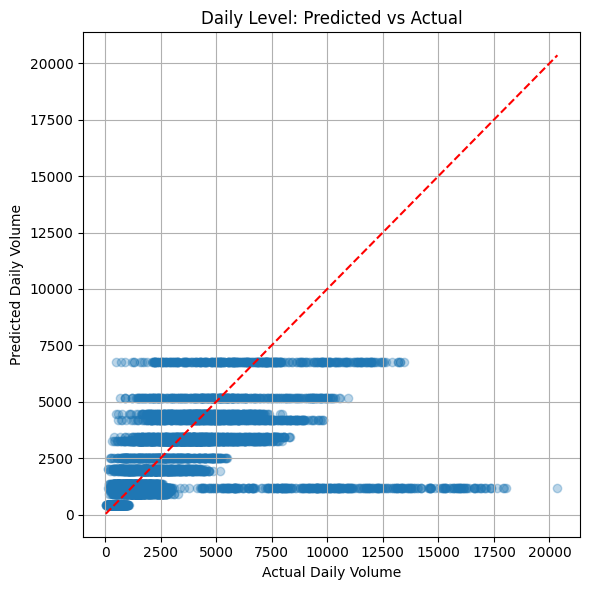

In [12]:
# Visualization of daily predictions
plt.figure(figsize=(6, 6))
plt.scatter(y_true_daily, y_pred_daily, alpha=0.3)
plt.plot([y_true_daily.min(), y_true_daily.max()],
         [y_true_daily.min(), y_true_daily.max()], 'r--')
plt.title("Daily Level: Predicted vs Actual")
plt.xlabel("Actual Daily Volume")
plt.ylabel("Predicted Daily Volume")
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
# AADB-Level Evaluation
aadb_df = test_df.dropna(subset=['cycling_volume', 'predicted_volume'])

aadb_actual = aadb_df.groupby(['station_name', 'year'])['cycling_volume'].mean()
aadb_pred = aadb_df.groupby(['station_name', 'year'])['predicted_volume'].mean()

aadb_eval = pd.concat([aadb_actual, aadb_pred], axis=1)
aadb_eval.columns = ['actual', 'predicted']

mae_aadb = mean_absolute_error(aadb_eval['actual'], aadb_eval['predicted'])
rmse_aadb = np.sqrt(mean_squared_error(aadb_eval['actual'], aadb_eval['predicted']))
smape_aadb = smape(aadb_eval['actual'], aadb_eval['predicted'])

print(f"\nAADB Level Evaluation:")
print(f"MAE  : {mae_aadb:.2f}")
print(f"RMSE : {rmse_aadb:.2f}")
print(f"SMAPE: {smape_aadb:.2f}%")


AADB Level Evaluation:
MAE  : 888.95
RMSE : 2252.85
SMAPE: 25.47%


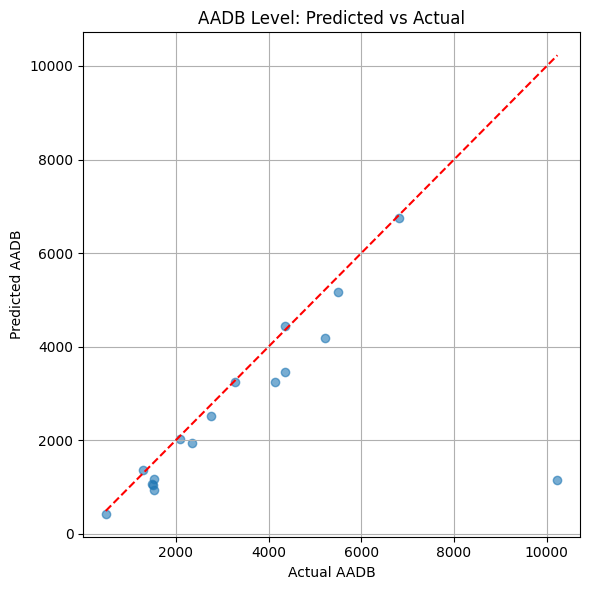

In [14]:
# Visualization of annual average daily cycling volume
plt.figure(figsize=(6, 6))
plt.scatter(aadb_eval['actual'], aadb_eval['predicted'], alpha=0.6)
plt.plot([aadb_eval['actual'].min(), aadb_eval['actual'].max()],
         [aadb_eval['actual'].min(), aadb_eval['actual'].max()], 'r--')
plt.title("AADB Level: Predicted vs Actual")
plt.xlabel("Actual AADB")
plt.ylabel("Predicted AADB")
plt.grid(True)
plt.tight_layout()
plt.show()

### Exponential Smoothing

In [15]:
# SMAPE Function
def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))
    )

# Load the dataset
df = pd.read_csv("processed_data_berlin_08042025.csv")

# Drop stations with ≤ 2 years of data
station_years = df.groupby('station_name')['year'].nunique()
valid_stations = station_years[station_years > 2].index
df = df[df['station_name'].isin(valid_stations)]

# Convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'])

In [16]:
# Exponential Smoothing
es_daily, es_aadb = [], []

for station in tqdm(df["station_name"].unique(), desc="ES (log‐space)"):
    data = df[df["station_name"] == station].sort_values("date")
    last_year = data['year'].max()
    train = data[data['year'] < 2023]
    test  = data[data['year'] == 2023]

    if train.empty or test.empty:
        continue

    # log‐transform
    y_train = np.log1p(train["cycling_volume"])

    # fit in log‐space
    model  = ExponentialSmoothing(
                  y_train,
                  trend='add',
                  seasonal='add',
                  seasonal_periods=7,
                  initialization_method="estimated"
              )
    fitted = model.fit()
    y_pred_log = fitted.forecast(steps=len(test))

    # back‐transform to original counts
    y_pred = np.expm1(y_pred_log).clip(lower=0)

    # daily metrics on original scale
    y_true = test["cycling_volume"].values
    es_daily.append([
        mean_absolute_error(y_true, y_pred),
        np.sqrt(mean_squared_error(y_true, y_pred)),
        smape(y_true, y_pred)
    ])

    # AADB (station‐year) metrics
    true_avg = y_true.mean()
    pred_avg = y_pred.mean()
    es_aadb.append([
        abs(true_avg - pred_avg),
        np.sqrt((true_avg - pred_avg)**2),
        smape(np.array([true_avg]), np.array([pred_avg]))
    ])


ES (log‐space):   6%|▌         | 1/17 [00:00<00:05,  2.71it/s]/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
ES (log‐space):  12%|█▏        | 2/17 [00:00<00:05,  2.86it/s]/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(da

ES (log‐space):  71%|███████   | 12/17 [00:04<00:01,  2.62it/s]/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
ES (log‐space):  76%|███████▋  | 13/17 [00:04<00:01,  2.77it/s]/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(

In [17]:
# Averages
es_daily = pd.DataFrame(es_daily, columns=["MAE","RMSE","SMAPE"])
es_aadb  = pd.DataFrame(es_aadb,  columns=["MAE","RMSE","SMAPE"])

print("ES Daily   :", es_daily.mean().to_dict())
print("ES AADB    :", es_aadb.mean().to_dict())

ES Daily   : {'MAE': 1959.3104834376334, 'RMSE': 2345.7621562156537, 'SMAPE': 71.7102291627577}
ES AADB    : {'MAE': 1917.8414178617675, 'RMSE': 1917.8414178617675, 'SMAPE': 77.86627114641564}


### ARIMA

In [18]:
# ARIMA
arima_daily = []
arima_aadb  = []

# Loop over stations
for station in tqdm(df['station_name'].unique(), desc='ARIMA (log-space)'):
    station_data = df[df['station_name'] == station].sort_values('date')
    last_year    = station_data['year'].max()
    
    train = station_data[station_data['year'] < last_year]
    test  = station_data[station_data['year'] == last_year]
    if train.empty or test.empty:
        continue

    # Log-transform the counts
    y_train = np.log1p(train['cycling_volume'])

    # Fit ARIMA on log-space
    model  = ARIMA(y_train, order=(1,1,1))
    fitted = model.fit()

    # Forecast in log-space
    y_pred_log = fitted.forecast(steps=len(test))

    # Back-transform to original scale & floor at zero
    y_pred = np.expm1(y_pred_log).clip(lower=0)

    # Daily-level metrics
    y_true = test['cycling_volume'].values
    arima_daily.append([
        mean_absolute_error(y_true, y_pred),
        np.sqrt(mean_squared_error(y_true, y_pred)),
        smape(y_true, y_pred)
    ])

    # AADB-level metrics (one value per station-year)
    true_avg = y_true.mean()
    pred_avg = y_pred.mean()
    arima_aadb.append([
        abs(true_avg - pred_avg),
        np.sqrt((true_avg - pred_avg)**2),
        smape(np.array([true_avg]), np.array([pred_avg]))
    ])


ARIMA (log-space):   6%|▌         | 1/17 [00:00<00:05,  2.70it/s]/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is

/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
ARIMA (log-space):  53%|█████▎    | 9/17 [00:02<00:02,  3.83it/s]/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/.local/lib/python3.8/site-packages/statsmodels/

ARIMA (log-space):  94%|█████████▍| 16/17 [00:04<00:00,  3.08it/s]/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index i

In [19]:
# Averages
arima_daily = pd.DataFrame(arima_daily, columns=['MAE','RMSE','SMAPE'])
arima_aadb  = pd.DataFrame(arima_aadb,  columns=['MAE','RMSE','SMAPE'])

print("ARIMA Daily   :", arima_daily.mean().to_dict())
print("ARIMA AADB    :", arima_aadb.mean().to_dict())

ARIMA Daily   : {'MAE': 2085.441977985603, 'RMSE': 2504.030663003102, 'SMAPE': 74.36766414815517}
ARIMA AADB    : {'MAE': 2016.4415147644343, 'RMSE': 2016.4415147644343, 'SMAPE': 81.0394228675385}


## Linear Regression (With Feature Selection)

In [20]:
# Let's load the dataset and remove the stations with less than 2 years of data
df = pd.read_csv("processed_data_berlin_08042025.csv")

# Drop stations with ≤ 2 years of data
station_years = df.groupby('station_name')['year'].nunique()
valid_stations = station_years[station_years > 2].index
df_filtered = df[df['station_name'].isin(valid_stations)]

In [21]:
# Let's define the SMAPE
def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) /
                                      (np.abs(y_true) + np.abs(y_pred)))

In [22]:
# Station-specific temporal train-test split
train_list, test_list = [], []

for station in df_filtered['station_name'].unique():
    station_data = df_filtered[df_filtered['station_name'] == station].sort_values('date')
    last_year = station_data['year'].max()

    train = station_data[station_data['year'] < last_year]
    test = station_data[station_data['year'] == last_year]

    if not train.empty and not test.empty:
        train_list.append(train)
        test_list.append(test)

train_df = pd.concat(train_list)
test_df = pd.concat(test_list)

In [23]:
print("Train/Test Set Overview:\n")

print(f"Train set: {len(train_df)} rows, {train_df['station_name'].nunique()} stations")
print(f"Test set : {len(test_df)} rows, {test_df['station_name'].nunique()} stations")

print(f"\nTrain years: {train_df['year'].unique()}")
print(f"Test years : {test_df['year'].unique()}")

Train/Test Set Overview:

Train set: 44543 rows, 17 stations
Test set : 6205 rows, 17 stations

Train years: [2015 2016 2017 2018 2019 2020 2021 2022]
Test years : [2023]


In [24]:
# Define features and target
non_features = ['station_name', 'date', 'year', 'cycling_volume', 'log_cycling_volume', 'num_motor_sources']
features = [col for col in df_filtered.columns if col not in non_features]

X_train = train_df[features]
y_train = train_df['log_cycling_volume']

X_test = test_df[features]
y_test_log = test_df['log_cycling_volume']
y_test_true = test_df['cycling_volume'] 

In [25]:
# RFE with Linear Regression and Cross-Validation
lr = LinearRegression()
scaler = StandardScaler()

# Pipeline with scaling and RFE
pipeline = Pipeline([
    ('scaler', scaler),
    ('feature_selection', RFECV(estimator=lr, step=1, cv=KFold(n_splits=5),
                                scoring='neg_mean_absolute_error', n_jobs=-1)),
    ('regression', lr)
])

pipeline.fit(X_train, y_train)

selected_features = X_train.columns[pipeline.named_steps['feature_selection'].support_]
print("\nSelected features by RFE for Linear Regression:")
print(selected_features.tolist())


Selected features by RFE for Linear Regression:
['private_gardening', 'city_total_motor_vehicles', 'city_total_cars']


In [26]:
# Prediction and back-transform
y_pred_log = pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)

# Drop NaNs (if any)
valid_idx = ~np.isnan(y_pred)
y_true_daily = y_test_true[valid_idx]
y_pred_daily = y_pred[valid_idx]

mae_daily = mean_absolute_error(y_true_daily, y_pred_daily)
rmse_daily = np.sqrt(mean_squared_error(y_true_daily, y_pred_daily))
smape_daily = smape(y_true_daily, y_pred_daily)

print(f"\nDaily Level Evaluation:")
print(f"MAE  : {mae_daily:.2f}")
print(f"RMSE : {rmse_daily:.2f}")
print(f"SMAPE: {smape_daily:.2f}%")


Daily Level Evaluation:
MAE  : 1766.32
RMSE : 2868.78
SMAPE: 53.14%


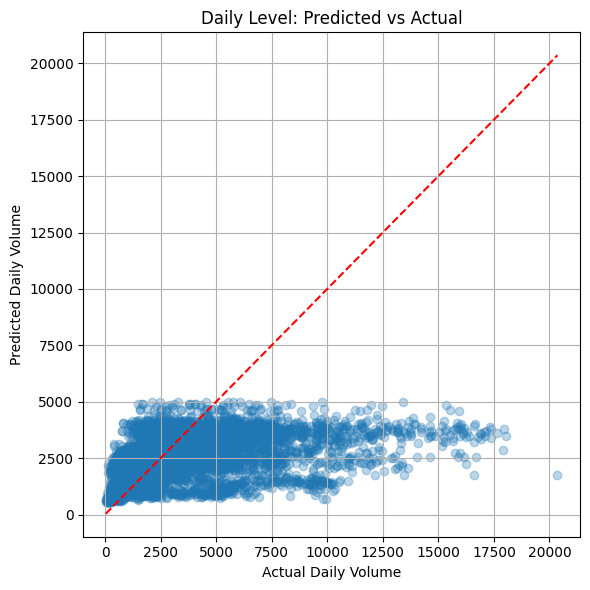

In [27]:
# Daily scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true_daily, y_pred_daily, alpha=0.3)
plt.plot([y_true_daily.min(), y_true_daily.max()],
         [y_true_daily.min(), y_true_daily.max()], 'r--')
plt.title("Daily Level: Predicted vs Actual")
plt.xlabel("Actual Daily Volume")
plt.ylabel("Predicted Daily Volume")
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
# AADB-Level Evaluation
test_df['predicted_volume'] = y_pred
aadb_actual = test_df.groupby(['station_name', 'year'])['cycling_volume'].mean()
aadb_pred = test_df.groupby(['station_name', 'year'])['predicted_volume'].mean()

aadb_eval = pd.concat([aadb_actual, aadb_pred], axis=1)
aadb_eval.columns = ['actual', 'predicted']

mae_aadb = mean_absolute_error(aadb_eval['actual'], aadb_eval['predicted'])
rmse_aadb = np.sqrt(mean_squared_error(aadb_eval['actual'], aadb_eval['predicted']))
smape_aadb = smape(aadb_eval['actual'], aadb_eval['predicted'])

print(f"\nAADB Level Evaluation:")
print(f"MAE  : {mae_aadb:.2f}")
print(f"RMSE : {rmse_aadb:.2f}")
print(f"SMAPE: {smape_aadb:.2f}%")


AADB Level Evaluation:
MAE  : 1568.71
RMSE : 2430.53
SMAPE: 44.13%


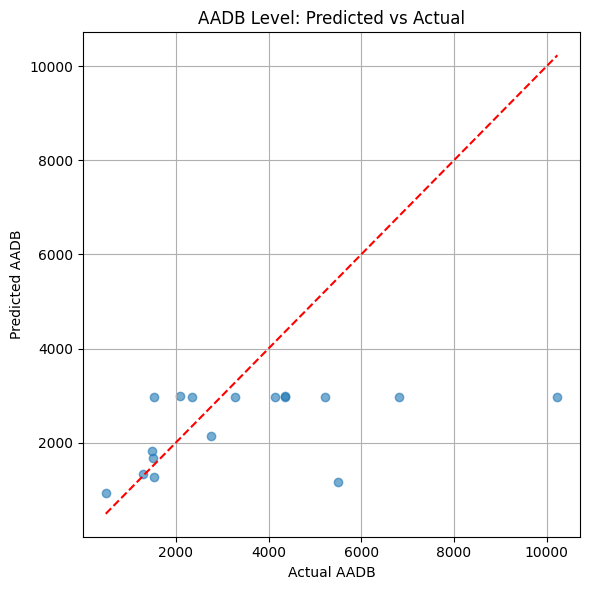

In [29]:
# AADB scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(aadb_eval['actual'], aadb_eval['predicted'], alpha=0.6)
plt.plot([aadb_eval['actual'].min(), aadb_eval['actual'].max()],
         [aadb_eval['actual'].min(), aadb_eval['actual'].max()], 'r--')
plt.title("AADB Level: Predicted vs Actual")
plt.xlabel("Actual AADB")
plt.ylabel("Predicted AADB")
plt.grid(True)
plt.tight_layout()
plt.show()

## Decision Tree Regressor (With Feature Selection and Hyperparameter Tuning)

In [30]:
# Let's load the dataset and remove the stations with less than 2 years of data
df = pd.read_csv("processed_data_berlin_08042025.csv")

# Drop stations with ≤ 2 years of data
station_years = df.groupby('station_name')['year'].nunique()
valid_stations = station_years[station_years > 2].index
df_filtered = df[df['station_name'].isin(valid_stations)]

In [31]:
# Station-specific temporal train-test split
train_list, test_list = [], []

for station in df_filtered['station_name'].unique():
    station_data = df_filtered[df_filtered['station_name'] == station].sort_values('date')
    last_year = station_data['year'].max()

    train = station_data[station_data['year'] < last_year]
    test = station_data[station_data['year'] == last_year]

    if not train.empty and not test.empty:
        train_list.append(train)
        test_list.append(test)

train_df = pd.concat(train_list)
test_df = pd.concat(test_list)

In [32]:
# Define features and target
non_features = ['station_name', 'date', 'year', 'cycling_volume', 'log_cycling_volume', 'num_motor_sources']
features = [col for col in df_filtered.columns if col not in non_features]

X_train = train_df[features]
y_train = train_df['log_cycling_volume']
X_test = test_df[features]
y_test_log = test_df['log_cycling_volume']
y_test_true = test_df['cycling_volume']

In [33]:
# Feature selection with Sequential Forward Selection
base_tree = DecisionTreeRegressor(random_state=42)
sfs = SequentialFeatureSelector(
    base_tree,
    n_features_to_select='auto',
    direction='forward',
    scoring='neg_mean_absolute_error',
    cv=KFold(n_splits=5),
    n_jobs=-1
)
sfs.fit(X_train, y_train)

selected_features = X_train.columns[sfs.get_support()]
print("\nSelected features by SFS for Decision Tree:")
print(selected_features.tolist())


Selected features by SFS for Decision Tree:
['longitude', 'education_within_2km', 'farming', 'horticulture', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wspd', 'wpgt', 'pres', 'tsun', 'wdir', 'public_holiday', 'avg_motor_volume', 'avg_car_speed', 'city_avg_motor_speed', 'city_avg_car_speed', 'city_total_motor_vehicles', 'city_total_cars', 'city_total_trucks', 'day_of_week', 'is_weekend', 'month', 'bicycle_lane_type_none', 'bicycle_lane_type_separate', 'bicycle_lane_type_sidepath', 'bicycle_lane_type_track', 'bicycle_lane_type_unknown']


In [34]:
# Step 2: Hyperparameter tuning with GridSearchCV
param_grid = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'criterion': ['squared_error', 'friedman_mse']
}

tree = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(
    tree,
    param_grid,
    scoring='neg_mean_absolute_error',
    cv=KFold(n_splits=5),
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train[selected_features], y_train)

print("\nBest hyperparameters:")
print(grid_search.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best hyperparameters:
{'criterion': 'friedman_mse', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5}


In [35]:
# Final Model: Train with best params
final_tree = grid_search.best_estimator_
y_pred_log = final_tree.predict(X_test[selected_features])
y_pred = np.expm1(y_pred_log)

# Let's define the SMAPE
def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) /
                                      (np.abs(y_true) + np.abs(y_pred)))

In [36]:
# Drop NaNs (if any)
valid_idx = ~np.isnan(y_pred)
y_true_daily = y_test_true[valid_idx]
y_pred_daily = y_pred[valid_idx]

# Set-up the daily level evaluation
mae_daily = mean_absolute_error(y_true_daily, y_pred_daily)
rmse_daily = np.sqrt(mean_squared_error(y_true_daily, y_pred_daily))
smape_daily = smape(y_true_daily, y_pred_daily)

print(f"\nDaily Level Evaluation:")
print(f"MAE  : {mae_daily:.2f}")
print(f"RMSE : {rmse_daily:.2f}")
print(f"SMAPE: {smape_daily:.2f}%")


Daily Level Evaluation:
MAE  : 775.27
RMSE : 1234.83
SMAPE: 26.42%


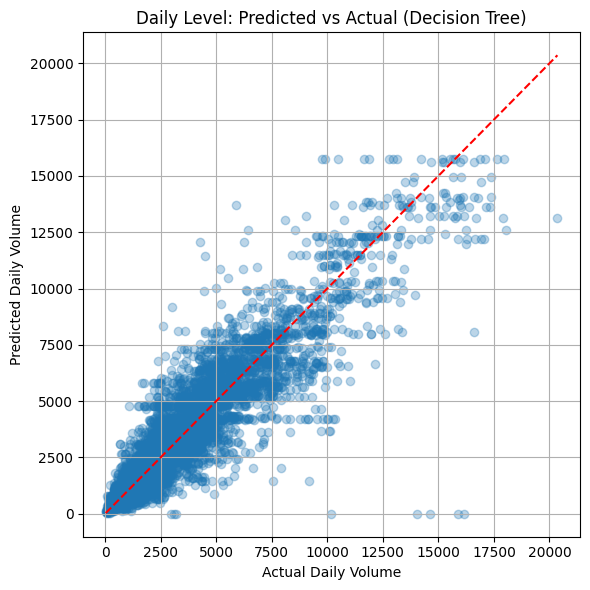

In [37]:
# Daily scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true_daily, y_pred_daily, alpha=0.3)
plt.plot([y_true_daily.min(), y_true_daily.max()],
         [y_true_daily.min(), y_true_daily.max()], 'r--')
plt.title("Daily Level: Predicted vs Actual (Decision Tree)")
plt.xlabel("Actual Daily Volume")
plt.ylabel("Predicted Daily Volume")
plt.grid(True)
plt.tight_layout()
plt.show()

In [38]:
# AADB evaluation
test_df['predicted_volume'] = y_pred
aadb_actual = test_df.groupby(['station_name', 'year'])['cycling_volume'].mean()
aadb_pred = test_df.groupby(['station_name', 'year'])['predicted_volume'].mean()

aadb_eval = pd.concat([aadb_actual, aadb_pred], axis=1)
aadb_eval.columns = ['actual', 'predicted']

mae_aadb = mean_absolute_error(aadb_eval['actual'], aadb_eval['predicted'])
rmse_aadb = np.sqrt(mean_squared_error(aadb_eval['actual'], aadb_eval['predicted']))
smape_aadb = smape(aadb_eval['actual'], aadb_eval['predicted'])

print(f"\nAADB Level Evaluation:")
print(f"MAE  : {mae_aadb:.2f}")
print(f"RMSE : {rmse_aadb:.2f}")
print(f"SMAPE: {smape_aadb:.2f}%")


AADB Level Evaluation:
MAE  : 285.99
RMSE : 410.26
SMAPE: 8.10%


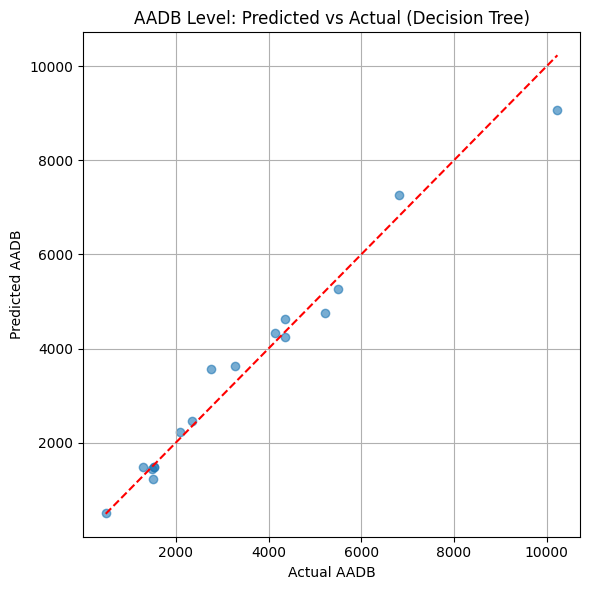

In [39]:
# AADB scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(aadb_eval['actual'], aadb_eval['predicted'], alpha=0.6)
plt.plot([aadb_eval['actual'].min(), aadb_eval['actual'].max()],
         [aadb_eval['actual'].min(), aadb_eval['actual'].max()], 'r--')
plt.title("AADB Level: Predicted vs Actual (Decision Tree)")
plt.xlabel("Actual AADB")
plt.ylabel("Predicted AADB")
plt.grid(True)
plt.tight_layout()
plt.show()

## Random Forest (With Feature Selection and Hyperparameter Tuning)

In [40]:
# Let's load the dataset and remove the stations with less than 2 years of data
df = pd.read_csv("processed_data_berlin_08042025.csv")

# Drop stations with ≤ 2 years of data
station_years = df.groupby('station_name')['year'].nunique()
valid_stations = station_years[station_years > 2].index
df_filtered = df[df['station_name'].isin(valid_stations)]

In [41]:
# Station-specific temporal train-test split
train_list, test_list = [], []

for station in df_filtered['station_name'].unique():
    station_data = df_filtered[df_filtered['station_name'] == station].sort_values('date')
    last_year = station_data['year'].max()
    train = station_data[station_data['year'] < last_year]
    test = station_data[station_data['year'] == last_year]
    if not train.empty and not test.empty:
        train_list.append(train)
        test_list.append(test)

train_df = pd.concat(train_list)
test_df = pd.concat(test_list)

In [42]:
# Define features and target
non_features = ['station_name', 'date', 'year', 'cycling_volume', 'log_cycling_volume', 'num_motor_sources']
features = [col for col in df_filtered.columns if col not in non_features]

X_train = train_df[features]
y_train = train_df['log_cycling_volume']
X_test = test_df[features]
y_test_log = test_df['log_cycling_volume']
y_test_true = test_df['cycling_volume']

In [43]:
# Feature selection using RFECV
rf_for_rfe = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

rfecv = RFECV(estimator=rf_for_rfe,
              step=1,
              cv=KFold(n_splits=5),
              scoring='neg_mean_absolute_error',
              n_jobs=-1,
              verbose=1)

rfecv.fit(X_train, y_train)

selected_features = X_train.columns[rfecv.support_]
print("\nSelected features by RFE for Random Forest:")
print(selected_features.tolist())

Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.

Selected features by RFE for Random Forest:
['longitude', 'shops_within_0km', 'shops_within_1km', '

In [44]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'bootstrap': [True, False]
}

rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(
    rf_model,
    param_grid,
    scoring='neg_mean_absolute_error',
    cv=KFold(n_splits=5),
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train[selected_features], y_train)

print("\nBest hyperparameters:")
print(grid_search.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best hyperparameters:
{'bootstrap': True, 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}


In [45]:
# Final Model Training and Prediction
final_rf = grid_search.best_estimator_
y_pred_log = final_rf.predict(X_test[selected_features])
y_pred = np.expm1(y_pred_log)

# Let's define the SMAPE function
def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) /
                                      (np.abs(y_true) + np.abs(y_pred)))

# Drop NaNs (if any)
valid_idx = ~np.isnan(y_pred)
y_true_daily = y_test_true[valid_idx]
y_pred_daily = y_pred[valid_idx]

In [46]:
# Evaluation at the daily level
mae_daily = mean_absolute_error(y_true_daily, y_pred_daily)
rmse_daily = np.sqrt(mean_squared_error(y_true_daily, y_pred_daily))
smape_daily = smape(y_true_daily, y_pred_daily)

print(f"\nDaily Level Evaluation:")
print(f"MAE  : {mae_daily:.2f}")
print(f"RMSE : {rmse_daily:.2f}")
print(f"SMAPE: {smape_daily:.2f}%")


Daily Level Evaluation:
MAE  : 1039.27
RMSE : 2441.02
SMAPE: 29.36%


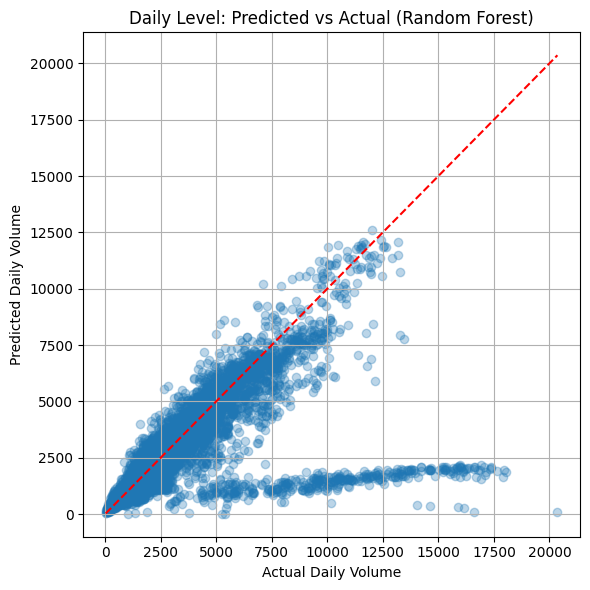

In [47]:
# Daily Scatter Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true_daily, y_pred_daily, alpha=0.3)
plt.plot([y_true_daily.min(), y_true_daily.max()],
         [y_true_daily.min(), y_true_daily.max()], 'r--')
plt.title("Daily Level: Predicted vs Actual (Random Forest)")
plt.xlabel("Actual Daily Volume")
plt.ylabel("Predicted Daily Volume")
plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
# AADB Evaluation
test_df['predicted_volume'] = y_pred
aadb_actual = test_df.groupby(['station_name', 'year'])['cycling_volume'].mean()
aadb_pred = test_df.groupby(['station_name', 'year'])['predicted_volume'].mean()

aadb_eval = pd.concat([aadb_actual, aadb_pred], axis=1)
aadb_eval.columns = ['actual', 'predicted']

mae_aadb = mean_absolute_error(aadb_eval['actual'], aadb_eval['predicted'])
rmse_aadb = np.sqrt(mean_squared_error(aadb_eval['actual'], aadb_eval['predicted']))
smape_aadb = smape(aadb_eval['actual'], aadb_eval['predicted'])

print(f"\nAADB Level Evaluation:")
print(f"MAE  : {mae_aadb:.2f}")
print(f"RMSE : {rmse_aadb:.2f}")
print(f"SMAPE: {smape_aadb:.2f}%")


AADB Level Evaluation:
MAE  : 740.74
RMSE : 2160.91
SMAPE: 18.05%


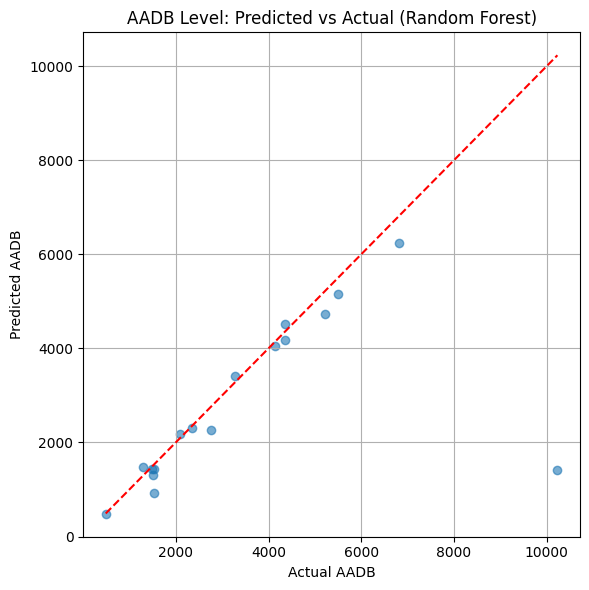

In [49]:
# AADB Scatter Plot
plt.figure(figsize=(6, 6))
plt.scatter(aadb_eval['actual'], aadb_eval['predicted'], alpha=0.6)
plt.plot([aadb_eval['actual'].min(), aadb_eval['actual'].max()],
         [aadb_eval['actual'].min(), aadb_eval['actual'].max()], 'r--')
plt.title("AADB Level: Predicted vs Actual (Random Forest)")
plt.xlabel("Actual AADB")
plt.ylabel("Predicted AADB")
plt.grid(True)
plt.tight_layout()
plt.show()

## Gradient Boosting (with Feature Selection and Hyperparameter Tuning)

In [49]:
# Load dataset and filter stations with more than 2 years of data
df = pd.read_csv("processed_data_berlin_08042025.csv")

station_years = df.groupby('station_name')['year'].nunique()
valid_stations = station_years[station_years > 2].index
df_filtered = df[df['station_name'].isin(valid_stations)]

In [50]:
# Train-test split by station and year
train_list, test_list = [], []
for station in df_filtered['station_name'].unique():
    station_data = df_filtered[df_filtered['station_name'] == station].sort_values('date')
    last_year = station_data['year'].max()
    train = station_data[station_data['year'] < last_year]
    test = station_data[station_data['year'] == last_year]
    if not train.empty and not test.empty:
        train_list.append(train)
        test_list.append(test)

train_df = pd.concat(train_list)
test_df = pd.concat(test_list)

In [51]:
# Define feature set
non_features = ['station_name', 'date', 'year', 'cycling_volume', 'log_cycling_volume', 'num_motor_sources']
features = [col for col in df_filtered.columns if col not in non_features]

X_train = train_df[features]
y_train = train_df['log_cycling_volume']
X_test = test_df[features]
y_test_log = test_df['log_cycling_volume']
y_test_true = test_df['cycling_volume']

In [52]:
# Feature selection with RFECV using Gradient Boosting
gb_for_rfe = GradientBoostingRegressor(n_estimators=100, random_state=42)

rfecv = RFECV(estimator=gb_for_rfe,
              step=1,
              cv=KFold(n_splits=5),
              scoring='neg_mean_absolute_error',
              n_jobs=-1,
              verbose=1)

rfecv.fit(X_train, y_train)

selected_features = X_train.columns[rfecv.support_]
print("\nSelected features by RFE for Gradient Boosting:")
print(selected_features.tolist())

Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 fe

In [53]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3]
}

gb_model = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(
    gb_model,
    param_grid,
    scoring='neg_mean_absolute_error',
    cv=KFold(n_splits=5),
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train[selected_features], y_train)

print("\nBest hyperparameters:")
print(grid_search.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best hyperparameters:
{'learning_rate': 0.1, 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}


In [54]:
# Final model and predictions
final_gb = grid_search.best_estimator_
y_pred_log = final_gb.predict(X_test[selected_features])
y_pred = np.expm1(y_pred_log)

# SMAPE definition
def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) /
                                      (np.abs(y_true) + np.abs(y_pred)))

In [55]:
# Drop NaNs if any
valid_idx = ~np.isnan(y_pred)
y_true_daily = y_test_true[valid_idx]
y_pred_daily = y_pred[valid_idx]

# Daily level evaluation
mae_daily = mean_absolute_error(y_true_daily, y_pred_daily)
rmse_daily = np.sqrt(mean_squared_error(y_true_daily, y_pred_daily))
smape_daily = smape(y_true_daily, y_pred_daily)

print(f"\nDaily Level Evaluation:")
print(f"MAE  : {mae_daily:.2f}")
print(f"RMSE : {rmse_daily:.2f}")
print(f"SMAPE: {smape_daily:.2f}%")


Daily Level Evaluation:
MAE  : 1063.54
RMSE : 2375.11
SMAPE: 30.41%


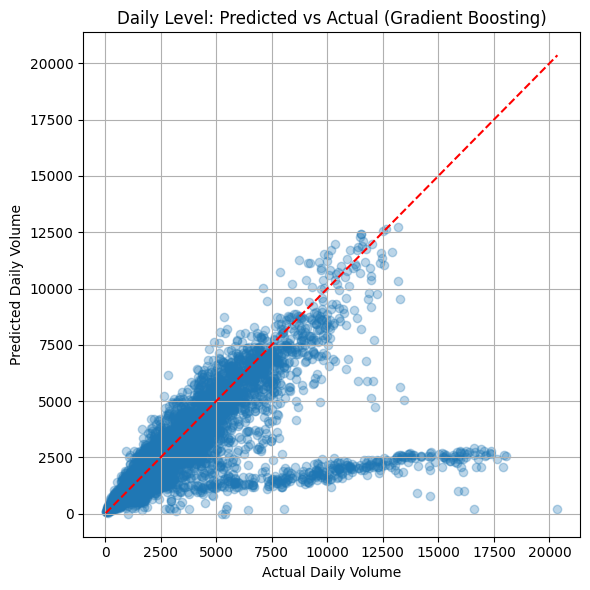

In [56]:
# Daily scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true_daily, y_pred_daily, alpha=0.3)
plt.plot([y_true_daily.min(), y_true_daily.max()],
         [y_true_daily.min(), y_true_daily.max()], 'r--')
plt.title("Daily Level: Predicted vs Actual (Gradient Boosting)")
plt.xlabel("Actual Daily Volume")
plt.ylabel("Predicted Daily Volume")
plt.grid(True)
plt.tight_layout()
plt.show()

In [57]:
# AADB evaluation
test_df['predicted_volume'] = y_pred
aadb_actual = test_df.groupby(['station_name', 'year'])['cycling_volume'].mean()
aadb_pred = test_df.groupby(['station_name', 'year'])['predicted_volume'].mean()

aadb_eval = pd.concat([aadb_actual, aadb_pred], axis=1)
aadb_eval.columns = ['actual', 'predicted']

mae_aadb = mean_absolute_error(aadb_eval['actual'], aadb_eval['predicted'])
rmse_aadb = np.sqrt(mean_squared_error(aadb_eval['actual'], aadb_eval['predicted']))
smape_aadb = smape(aadb_eval['actual'], aadb_eval['predicted'])

print(f"\nAADB Level Evaluation:")
print(f"MAE  : {mae_aadb:.2f}")
print(f"RMSE : {rmse_aadb:.2f}")
print(f"SMAPE: {smape_aadb:.2f}%")


AADB Level Evaluation:
MAE  : 779.76
RMSE : 2075.50
SMAPE: 19.56%


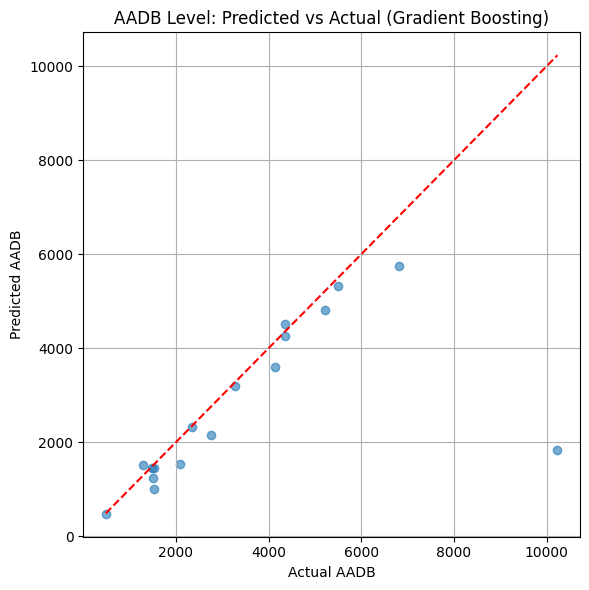

In [51]:
# AADB scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(aadb_eval['actual'], aadb_eval['predicted'], alpha=0.6)
plt.plot([aadb_eval['actual'].min(), aadb_eval['actual'].max()],
         [aadb_eval['actual'].min(), aadb_eval['actual'].max()], 'r--')
plt.title("AADB Level: Predicted vs Actual (Gradient Boosting)")
plt.xlabel("Actual AADB")
plt.ylabel("Predicted AADB")
plt.grid(True)
plt.tight_layout()
plt.show()

## XGBoost (With Feature Selection and Hyperparameter Tuning)

In [58]:
# Let's load the dataset and remove the stations with less than 2 years of data
df = pd.read_csv("processed_data_berlin_08042025.csv")

# Drop stations with ≤ 2 years of data
station_years = df.groupby('station_name')['year'].nunique()
valid_stations = station_years[station_years > 2].index
df_filtered = df[df['station_name'].isin(valid_stations)]

In [59]:
# Station-wise temporal train-test split
train_list, test_list = [], []

for station in df_filtered['station_name'].unique():
    station_data = df_filtered[df_filtered['station_name'] == station].sort_values('date')
    last_year = station_data['year'].max()
    train = station_data[station_data['year'] < last_year]
    test = station_data[station_data['year'] == last_year]
    if not train.empty and not test.empty:
        train_list.append(train)
        test_list.append(test)

train_df = pd.concat(train_list)
test_df = pd.concat(test_list)

In [60]:
# Define features and target
non_features = ['station_name', 'date', 'year', 'cycling_volume', 'log_cycling_volume', 'num_motor_sources']
features = [col for col in df_filtered.columns if col not in non_features]

X_train = train_df[features]
y_train = train_df['log_cycling_volume']
X_test = test_df[features]
y_test_log = test_df['log_cycling_volume']
y_test_true = test_df['cycling_volume']

In [61]:
# Feature selection using Sequential Forward Selection
xgb_for_sfs = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

sfs = SequentialFeatureSelector(
    xgb_for_sfs,
    n_features_to_select='auto',
    direction='forward',
    scoring='neg_mean_absolute_error',
    cv=KFold(n_splits=5),
    n_jobs=-1
)
sfs.fit(X_train, y_train)

selected_features = X_train.columns[sfs.get_support()]
print("\nSelected features by SFS for XGBoost:")
print(selected_features.tolist())


Selected features by SFS for XGBoost:
['shops_within_0km', 'shops_within_1km', 'shops_within_5km', 'hospitals_within_0km', 'hospitals_within_1km', 'hospitals_within_2km', 'hospitals_within_5km', 'cemeteries', 'farming', 'forests', 'horticulture', 'industry', 'parks', 'waterways', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wspd', 'wpgt', 'pres', 'tsun', 'wdir', 'public_holiday', 'month', 'bicycle_lane_type_separate', 'bicycle_lane_type_sidepath', 'bicycle_lane_type_track', 'bicycle_lane_type_unknown']


In [62]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [5, 10],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 5],
    'gamma': [0, 1]
}

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
grid_search = GridSearchCV(
    xgb_model,
    param_grid,
    scoring='neg_mean_absolute_error',
    cv=KFold(n_splits=5),
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train[selected_features], y_train)

print("\nBest hyperparameters for XGBoost:")
print(grid_search.best_params_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits

Best hyperparameters for XGBoost:
{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 1.0}


In [63]:
# Final Model: Train with best parameters
final_xgb = grid_search.best_estimator_
y_pred_log = final_xgb.predict(X_test[selected_features])
y_pred = np.expm1(y_pred_log)

In [64]:
# Evaluation metrics
def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) /
                                      (np.abs(y_true) + np.abs(y_pred)))

valid_idx = ~np.isnan(y_pred)
y_true_daily = y_test_true[valid_idx]
y_pred_daily = y_pred[valid_idx]

mae_daily = mean_absolute_error(y_true_daily, y_pred_daily)
rmse_daily = np.sqrt(mean_squared_error(y_true_daily, y_pred_daily))
smape_daily = smape(y_true_daily, y_pred_daily)

print(f"\nDaily Level Evaluation:")
print(f"MAE  : {mae_daily:.2f}")
print(f"RMSE : {rmse_daily:.2f}")
print(f"SMAPE: {smape_daily:.2f}%")


Daily Level Evaluation:
MAE  : 1393.06
RMSE : 2887.87
SMAPE: 41.68%


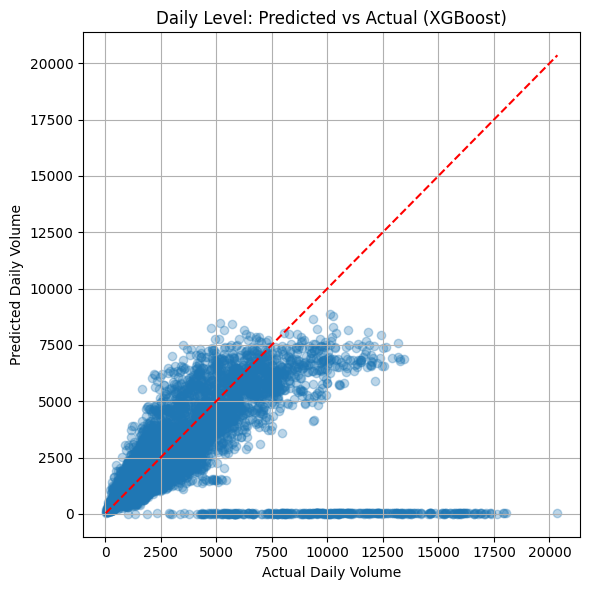

In [65]:
# Scatter plot at the daily level
plt.figure(figsize=(6, 6))
plt.scatter(y_true_daily, y_pred_daily, alpha=0.3)
plt.plot([y_true_daily.min(), y_true_daily.max()],
         [y_true_daily.min(), y_true_daily.max()], 'r--')
plt.title("Daily Level: Predicted vs Actual (XGBoost)")
plt.xlabel("Actual Daily Volume")
plt.ylabel("Predicted Daily Volume")
plt.grid(True)
plt.tight_layout()
plt.show()

In [66]:
# AADB evaluation
test_df['predicted_volume'] = y_pred
aadb_actual = test_df.groupby(['station_name', 'year'])['cycling_volume'].mean()
aadb_pred = test_df.groupby(['station_name', 'year'])['predicted_volume'].mean()

aadb_eval = pd.concat([aadb_actual, aadb_pred], axis=1)
aadb_eval.columns = ['actual', 'predicted']

mae_aadb = mean_absolute_error(aadb_eval['actual'], aadb_eval['predicted'])
rmse_aadb = np.sqrt(mean_squared_error(aadb_eval['actual'], aadb_eval['predicted']))
smape_aadb = smape(aadb_eval['actual'], aadb_eval['predicted'])

print(f"\nAADB Level Evaluation:")
print(f"MAE  : {mae_aadb:.2f}")
print(f"RMSE : {rmse_aadb:.2f}")
print(f"SMAPE: {smape_aadb:.2f}%")


AADB Level Evaluation:
MAE  : 923.51
RMSE : 2519.86
SMAPE: 23.96%


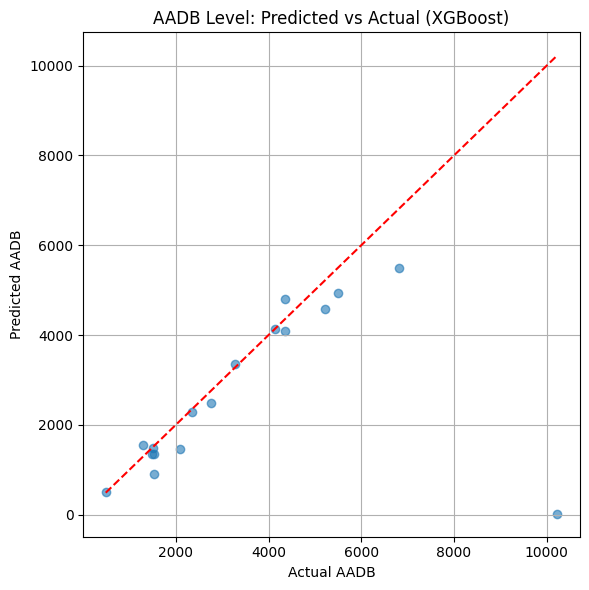

In [67]:
# Scatter plot at the AADB level
plt.figure(figsize=(6, 6))
plt.scatter(aadb_eval['actual'], aadb_eval['predicted'], alpha=0.6)
plt.plot([aadb_eval['actual'].min(), aadb_eval['actual'].max()],
         [aadb_eval['actual'].min(), aadb_eval['actual'].max()], 'r--')
plt.title("AADB Level: Predicted vs Actual (XGBoost)")
plt.xlabel("Actual AADB")
plt.ylabel("Predicted AADB")
plt.grid(True)
plt.tight_layout()
plt.show()

## Support Vector Regression (SelectKBest and Hyperparameter Tuning)

In [5]:
# Let's load the dataset and remove the stations with less than 2 years of data
df = pd.read_csv("processed_data_berlin_08042025.csv")

# Drop stations with ≤ 2 years of data
station_years = df.groupby('station_name')['year'].nunique()
valid_stations = station_years[station_years > 2].index
df_filtered = df[df['station_name'].isin(valid_stations)]

In [6]:
# Station-wise temporal train-test split
train_list, test_list = [], []

for station in df_filtered['station_name'].unique():
    station_data = df_filtered[df_filtered['station_name'] == station].sort_values('date')
    last_year = station_data['year'].max()
    train = station_data[station_data['year'] < last_year]
    test = station_data[station_data['year'] == last_year]
    if not train.empty and not test.empty:
        train_list.append(train)
        test_list.append(test)

train_df = pd.concat(train_list)
test_df = pd.concat(test_list)

In [7]:
# Define features and target
non_features = ['station_name', 'date', 'year', 'cycling_volume', 'log_cycling_volume', 'num_motor_sources']
features = [col for col in df_filtered.columns if col not in non_features]

X_train = train_df[features]
y_train = train_df['log_cycling_volume']
X_test = test_df[features]
y_test_log = test_df['log_cycling_volume']
y_test_true = test_df['cycling_volume']

In [8]:
# Pipeline: Scaling → Feature Selection → SVR
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('select_k_best', SelectKBest(score_func=f_regression, k=15)),  # Selecting only 15 features here
    ('svr', SVR())
])

In [9]:
# Hyperparameter grid
param_grid = {
    'svr__kernel': ['linear', 'rbf', 'poly'],
    'svr__C': [1, 10, 100],
    'svr__epsilon': [0.1, 0.5],
    'svr__gamma': ['scale', 'auto'],
    'svr__degree': [2, 3]  # only used for 'poly' kernel
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='neg_mean_absolute_error',
    cv=KFold(n_splits=5),
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

print("\nBest hyperparameters for SVR:")
print(grid_search.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best hyperparameters for SVR:
{'svr__C': 1, 'svr__degree': 2, 'svr__epsilon': 0.1, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}


In [10]:
# Final model predictions
y_pred_log = grid_search.predict(X_test)
y_pred = np.expm1(y_pred_log)

In [11]:
# Define the SMAPE function
def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) /
                                      (np.abs(y_true) + np.abs(y_pred)))

valid_idx = ~np.isnan(y_pred)
y_true_daily = y_test_true[valid_idx]
y_pred_daily = y_pred[valid_idx]

# Evaluation at the daily level
mae_daily = mean_absolute_error(y_true_daily, y_pred_daily)
rmse_daily = np.sqrt(mean_squared_error(y_true_daily, y_pred_daily))
smape_daily = smape(y_true_daily, y_pred_daily)

print(f"\nDaily Level Evaluation:")
print(f"MAE  : {mae_daily:.2f}")
print(f"RMSE : {rmse_daily:.2f}")
print(f"SMAPE: {smape_daily:.2f}%")


Daily Level Evaluation:
MAE  : 798.61
RMSE : 1374.63
SMAPE: 25.57%


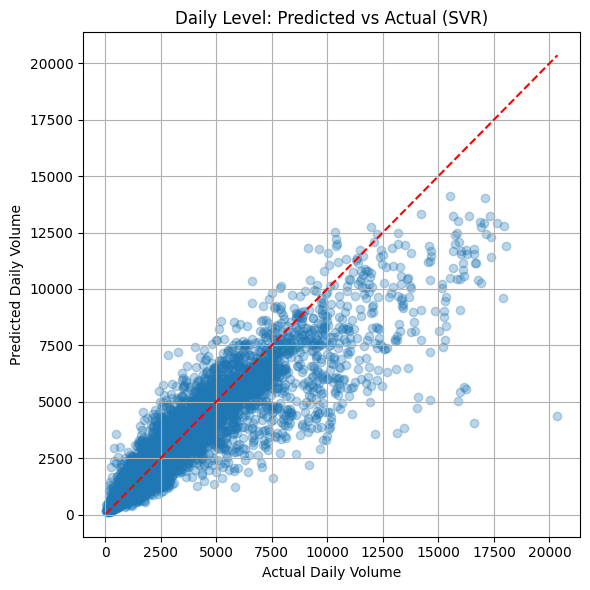

In [12]:
# Scatterplot at the daily level
plt.figure(figsize=(6, 6))
plt.scatter(y_true_daily, y_pred_daily, alpha=0.3)
plt.plot([y_true_daily.min(), y_true_daily.max()],
         [y_true_daily.min(), y_true_daily.max()], 'r--')
plt.title("Daily Level: Predicted vs Actual (SVR)")
plt.xlabel("Actual Daily Volume")
plt.ylabel("Predicted Daily Volume")
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
# AADB Evaluation
test_df['predicted_volume'] = y_pred
aadb_actual = test_df.groupby(['station_name', 'year'])['cycling_volume'].mean()
aadb_pred = test_df.groupby(['station_name', 'year'])['predicted_volume'].mean()

aadb_eval = pd.concat([aadb_actual, aadb_pred], axis=1)
aadb_eval.columns = ['actual', 'predicted']

mae_aadb = mean_absolute_error(aadb_eval['actual'], aadb_eval['predicted'])
rmse_aadb = np.sqrt(mean_squared_error(aadb_eval['actual'], aadb_eval['predicted']))
smape_aadb = smape(aadb_eval['actual'], aadb_eval['predicted'])

print(f"\nAADB Level Evaluation:")
print(f"MAE  : {mae_aadb:.2f}")
print(f"RMSE : {rmse_aadb:.2f}")
print(f"SMAPE: {smape_aadb:.2f}%")


AADB Level Evaluation:
MAE  : 387.99
RMSE : 962.88
SMAPE: 10.77%


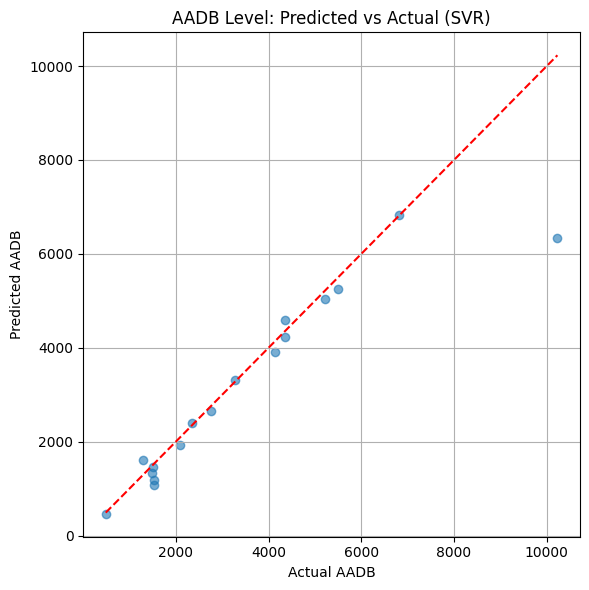

In [14]:
# Scatter Plot at the AADB Level
plt.figure(figsize=(6, 6))
plt.scatter(aadb_eval['actual'], aadb_eval['predicted'], alpha=0.6)
plt.plot([aadb_eval['actual'].min(), aadb_eval['actual'].max()],
         [aadb_eval['actual'].min(), aadb_eval['actual'].max()], 'r--')
plt.title("AADB Level: Predicted vs Actual (SVR)")
plt.xlabel("Actual AADB")
plt.ylabel("Predicted AADB")
plt.grid(True)
plt.tight_layout()
plt.show()

## Shallow Neural Network (SelectKBest and Hyperparameter Tuning)

In [68]:
# Let's load the dataset and remove the stations with less than 2 years of data
df = pd.read_csv("processed_data_berlin_08042025.csv")

# Drop stations with ≤ 2 years of data
station_years = df.groupby('station_name')['year'].nunique()
valid_stations = station_years[station_years > 2].index
df_filtered = df[df['station_name'].isin(valid_stations)]

In [69]:
# Station-wise temporal train-test split
train_list, test_list = [], []

for station in df_filtered['station_name'].unique():
    station_data = df_filtered[df_filtered['station_name'] == station].sort_values('date')
    last_year = station_data['year'].max()
    train = station_data[station_data['year'] < last_year]
    test = station_data[station_data['year'] == last_year]
    if not train.empty and not test.empty:
        train_list.append(train)
        test_list.append(test)

train_df = pd.concat(train_list)
test_df = pd.concat(test_list)

In [70]:
# Define features and target
non_features = ['station_name', 'date', 'year', 'cycling_volume', 'log_cycling_volume', 'num_motor_sources']
features = [col for col in df_filtered.columns if col not in non_features]

X_train = train_df[features]
y_train = train_df['log_cycling_volume']
X_test = test_df[features]
y_test_log = test_df['log_cycling_volume']
y_test_true = test_df['cycling_volume']

In [71]:
# Pipeline: Scale → Feature selection → MLP
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('select_k_best', SelectKBest(score_func=f_regression, k=31)),
    ('mlp', MLPRegressor(max_iter=500, random_state=42))
])

In [72]:
# Hyperparameter grid
param_grid = {
    'mlp__hidden_layer_sizes': [(10,), (50,), (100,)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__learning_rate_init': [0.001, 0.01]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='neg_mean_absolute_error',
    cv=KFold(n_splits=5),
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

print("\nBest hyperparameters for SNN:")
print(grid_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best hyperparameters for SNN:
{'mlp__activation': 'tanh', 'mlp__hidden_layer_sizes': (10,), 'mlp__learning_rate_init': 0.01}


In [73]:
# Final model predictions
y_pred_log = grid_search.predict(X_test)
y_pred = np.expm1(y_pred_log)

In [74]:
# Deine the SMAPE function
def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) /
                                      (np.abs(y_true) + np.abs(y_pred)))

valid_idx = ~np.isnan(y_pred)
y_true_daily = y_test_true[valid_idx]
y_pred_daily = y_pred[valid_idx]

# Evaluation at the daily level
mae_daily = mean_absolute_error(y_true_daily, y_pred_daily)
rmse_daily = np.sqrt(mean_squared_error(y_true_daily, y_pred_daily))
smape_daily = smape(y_true_daily, y_pred_daily)

print(f"\nDaily Level Evaluation:")
print(f"MAE  : {mae_daily:.2f}")
print(f"RMSE : {rmse_daily:.2f}")
print(f"SMAPE: {smape_daily:.2f}%")


Daily Level Evaluation:
MAE  : 1007.85
RMSE : 1741.18
SMAPE: 30.83%


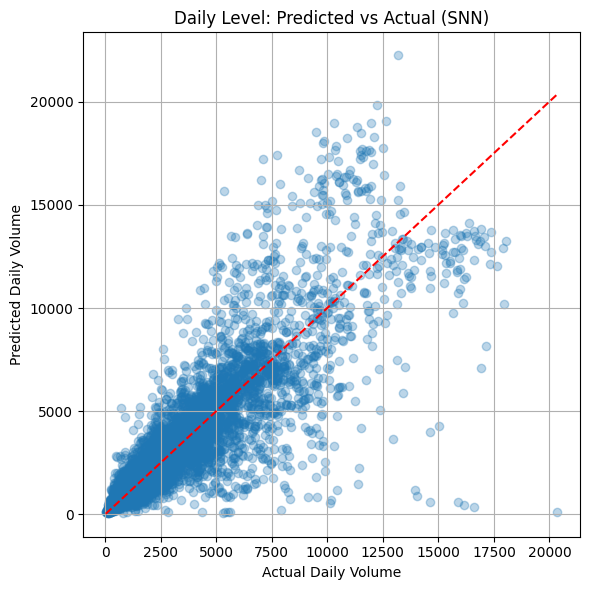

In [75]:
# Scatter plot at the daily level
plt.figure(figsize=(6, 6))
plt.scatter(y_true_daily, y_pred_daily, alpha=0.3)
plt.plot([y_true_daily.min(), y_true_daily.max()],
         [y_true_daily.min(), y_true_daily.max()], 'r--')
plt.title("Daily Level: Predicted vs Actual (SNN)")
plt.xlabel("Actual Daily Volume")
plt.ylabel("Predicted Daily Volume")
plt.grid(True)
plt.tight_layout()
plt.show()

In [76]:
# AADB Evaluation
test_df['predicted_volume'] = y_pred
aadb_actual = test_df.groupby(['station_name', 'year'])['cycling_volume'].mean()
aadb_pred = test_df.groupby(['station_name', 'year'])['predicted_volume'].mean()

aadb_eval = pd.concat([aadb_actual, aadb_pred], axis=1)
aadb_eval.columns = ['actual', 'predicted']

mae_aadb = mean_absolute_error(aadb_eval['actual'], aadb_eval['predicted'])
rmse_aadb = np.sqrt(mean_squared_error(aadb_eval['actual'], aadb_eval['predicted']))
smape_aadb = smape(aadb_eval['actual'], aadb_eval['predicted'])

print(f"\nAADB Level Evaluation:")
print(f"MAE  : {mae_aadb:.2f}")
print(f"RMSE : {rmse_aadb:.2f}")
print(f"SMAPE: {smape_aadb:.2f}%")


AADB Level Evaluation:
MAE  : 775.51
RMSE : 1213.34
SMAPE: 20.40%


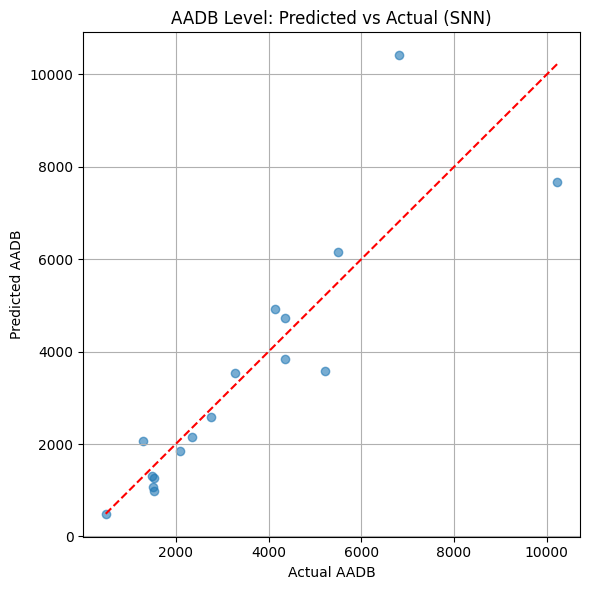

In [77]:
# Scatter plot at the AADB level
plt.figure(figsize=(6, 6))
plt.scatter(aadb_eval['actual'], aadb_eval['predicted'], alpha=0.6)
plt.plot([aadb_eval['actual'].min(), aadb_eval['actual'].max()],
         [aadb_eval['actual'].min(), aadb_eval['actual'].max()], 'r--')
plt.title("AADB Level: Predicted vs Actual (SNN)")
plt.xlabel("Actual AADB")
plt.ylabel("Predicted AADB")
plt.grid(True)
plt.tight_layout()
plt.show()

## Deep Neural Network (PCA and Hyperparameter Tuning)

In [78]:
# Let's load the dataset and remove the stations with less than 2 years of data
df = pd.read_csv("processed_data_berlin_08042025.csv")

# Drop stations with ≤ 2 years of data
station_years = df.groupby('station_name')['year'].nunique()
valid_stations = station_years[station_years > 2].index
df_filtered = df[df['station_name'].isin(valid_stations)]

In [79]:
# Station-wise temporal train-test split
train_list, test_list = [], []

for station in df_filtered['station_name'].unique():
    station_data = df_filtered[df_filtered['station_name'] == station].sort_values('date')
    last_year = station_data['year'].max()
    train = station_data[station_data['year'] < last_year]
    test = station_data[station_data['year'] == last_year]
    if not train.empty and not test.empty:
        train_list.append(train)
        test_list.append(test)

train_df = pd.concat(train_list)
test_df = pd.concat(test_list)

In [80]:
# Define features and target
non_features = ['station_name', 'date', 'year', 'cycling_volume', 'log_cycling_volume', 'num_motor_sources']
features = [col for col in df_filtered.columns if col not in non_features]

X_train = train_df[features]
y_train = train_df['log_cycling_volume']
X_test = test_df[features]
y_test_log = test_df['log_cycling_volume']
y_test_true = test_df['cycling_volume']

In [81]:
# Pipeline: Scale → PCA → Deep MLP
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=20)),
    ('mlp', MLPRegressor(max_iter=500, random_state=42))
])

In [82]:
# Hyperparameter grid
param_grid = {
    'mlp__hidden_layer_sizes': [(50, 50), (100, 50), (100, 100)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__learning_rate_init': [0.001, 0.01]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='neg_mean_absolute_error',
    cv=KFold(n_splits=5),
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

print("\nBest hyperparameters for DNN:")
print(grid_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best hyperparameters for DNN:
{'mlp__activation': 'tanh', 'mlp__hidden_layer_sizes': (100, 50), 'mlp__learning_rate_init': 0.001}


In [83]:
# Final model predictions
y_pred_log = grid_search.predict(X_test)
y_pred = np.expm1(y_pred_log)

In [84]:
# Define the SMAPE
def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) /
                                      (np.abs(y_true) + np.abs(y_pred)))

# Drop NaNs (if there are any)
valid_idx = ~np.isnan(y_pred)
y_true_daily = y_test_true[valid_idx]
y_pred_daily = y_pred[valid_idx]

# Evaluation at the daily level
mae_daily = mean_absolute_error(y_true_daily, y_pred_daily)
rmse_daily = np.sqrt(mean_squared_error(y_true_daily, y_pred_daily))
smape_daily = smape(y_true_daily, y_pred_daily)

print(f"\nDaily Level Evaluation:")
print(f"MAE  : {mae_daily:.2f}")
print(f"RMSE : {rmse_daily:.2f}")
print(f"SMAPE: {smape_daily:.2f}%")


Daily Level Evaluation:
MAE  : 731.45
RMSE : 1186.20
SMAPE: 26.84%


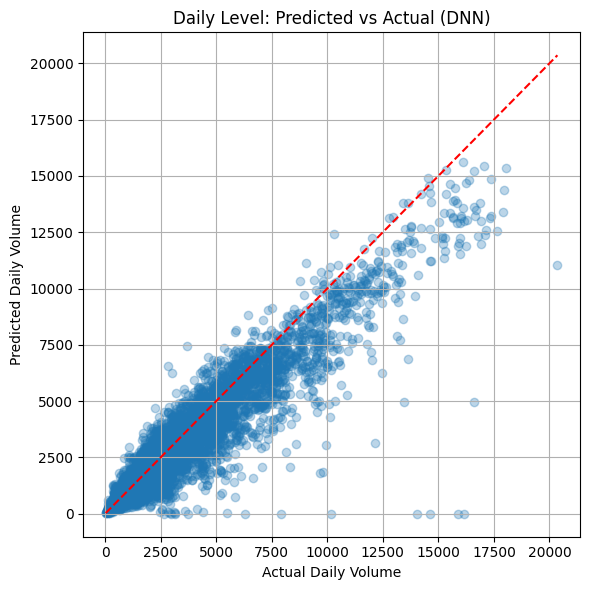

In [85]:
# Scatter plot at the daily level
plt.figure(figsize=(6, 6))
plt.scatter(y_true_daily, y_pred_daily, alpha=0.3)
plt.plot([y_true_daily.min(), y_true_daily.max()],
         [y_true_daily.min(), y_true_daily.max()], 'r--')
plt.title("Daily Level: Predicted vs Actual (DNN)")
plt.xlabel("Actual Daily Volume")
plt.ylabel("Predicted Daily Volume")
plt.grid(True)
plt.tight_layout()
plt.show()

In [86]:
# AADB Evaluation
test_df['predicted_volume'] = y_pred
aadb_actual = test_df.groupby(['station_name', 'year'])['cycling_volume'].mean()
aadb_pred = test_df.groupby(['station_name', 'year'])['predicted_volume'].mean()

aadb_eval = pd.concat([aadb_actual, aadb_pred], axis=1)
aadb_eval.columns = ['actual', 'predicted']

mae_aadb = mean_absolute_error(aadb_eval['actual'], aadb_eval['predicted'])
rmse_aadb = np.sqrt(mean_squared_error(aadb_eval['actual'], aadb_eval['predicted']))
smape_aadb = smape(aadb_eval['actual'], aadb_eval['predicted'])

print(f"\nAADB Level Evaluation:")
print(f"MAE  : {mae_aadb:.2f}")
print(f"RMSE : {rmse_aadb:.2f}")
print(f"SMAPE: {smape_aadb:.2f}%")


AADB Level Evaluation:
MAE  : 457.67
RMSE : 665.17
SMAPE: 14.67%


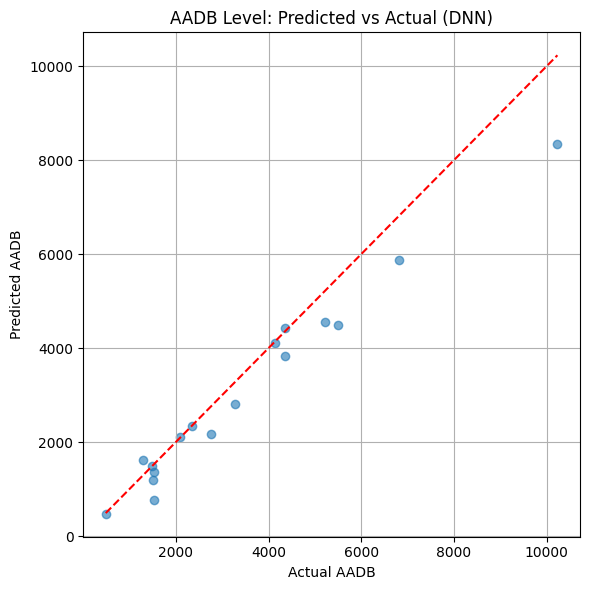

In [87]:
# Scatter plot at the AADB level
plt.figure(figsize=(6, 6))
plt.scatter(aadb_eval['actual'], aadb_eval['predicted'], alpha=0.6)
plt.plot([aadb_eval['actual'].min(), aadb_eval['actual'].max()],
         [aadb_eval['actual'].min(), aadb_eval['actual'].max()], 'r--')
plt.title("AADB Level: Predicted vs Actual (DNN)")
plt.xlabel("Actual AADB")
plt.ylabel("Predicted AADB")
plt.grid(True)
plt.tight_layout()
plt.show()

## LSTM Model

In [6]:
# Some CONFIG
n_steps = 30
epochs = 30
batch_size = 32
lstm_units = 64
dropout_rate = 0.2

In [7]:
# Let's load the dataset and remove the stations with less than 2 years of data
df = pd.read_csv("processed_data_berlin_08042025.csv")

# Drop stations with ≤ 2 years of data
station_years = df.groupby('station_name')['year'].nunique()
valid_stations = station_years[station_years > 2].index
df = df[df['station_name'].isin(valid_stations)]

non_features = ['station_name', 'date', 'year', 'cycling_volume', 'log_cycling_volume', 'num_motor_sources']
features = [col for col in df.columns if col not in non_features]

In [8]:
# --- STORING RESULTS ---
all_preds, all_actuals = [], []
aadb_results = []

def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

In [9]:
# --- PER STATION MODEL ---
for station in df['station_name'].unique():
    station_data = df[df['station_name'] == station].sort_values('date').copy()
    
    train_data = station_data[station_data['year'] < 2023]
    test_data = station_data[station_data['year'] == 2023]
    
    if len(train_data) < n_steps or test_data.empty:
        continue

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(train_data[features])
    y = train_data['log_cycling_volume'].values

    X_seq, y_seq = [], []
    for i in range(n_steps, len(X_scaled)):
        X_seq.append(X_scaled[i - n_steps:i])
        y_seq.append(y[i])
    
    X_seq, y_seq = np.array(X_seq), np.array(y_seq)

    # Define model
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(n_steps, len(features))))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_seq, y_seq, epochs=epochs, batch_size=batch_size, verbose=0)

    # Prepare test sequences
    X_test_scaled = scaler.transform(test_data[features])
    y_test_true = test_data['cycling_volume'].values
    y_test_log = test_data['log_cycling_volume'].values

    X_test_seq, y_test_actual = [], []
    for i in range(n_steps, len(X_test_scaled)):
        X_test_seq.append(X_test_scaled[i - n_steps:i])
        y_test_actual.append(y_test_true[i])

    if not X_test_seq:
        continue

    X_test_seq = np.array(X_test_seq)
    y_pred_log = model.predict(X_test_seq).flatten()
    y_pred = np.expm1(y_pred_log)

    # --- Daily metrics ---
    y_true = np.array(y_test_actual)
    all_preds.extend(y_pred)
    all_actuals.extend(y_true)

    # --- AADB per station ---
    pred_2023 = pd.Series(y_pred, index=test_data.iloc[n_steps:].index)
    test_data.loc[pred_2023.index, 'predicted_volume'] = pred_2023

    aadb_actual = test_data.groupby('year')['cycling_volume'].mean().values[0]
    aadb_pred = test_data.groupby('year')['predicted_volume'].mean().values[0]
    aadb_results.append((station, aadb_actual, aadb_pred))

11/11 [==============================] - 0s 2ms/step


<ipython-input-9-734e32ff4ee1>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[pred_2023.index, 'predicted_volume'] = pred_2023


11/11 [==============================] - 0s 2ms/step


<ipython-input-9-734e32ff4ee1>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[pred_2023.index, 'predicted_volume'] = pred_2023


11/11 [==============================] - 0s 3ms/step


<ipython-input-9-734e32ff4ee1>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[pred_2023.index, 'predicted_volume'] = pred_2023


11/11 [==============================] - 0s 3ms/step


<ipython-input-9-734e32ff4ee1>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[pred_2023.index, 'predicted_volume'] = pred_2023


11/11 [==============================] - 0s 3ms/step


<ipython-input-9-734e32ff4ee1>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[pred_2023.index, 'predicted_volume'] = pred_2023


11/11 [==============================] - 0s 3ms/step


<ipython-input-9-734e32ff4ee1>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[pred_2023.index, 'predicted_volume'] = pred_2023


11/11 [==============================] - 0s 3ms/step


<ipython-input-9-734e32ff4ee1>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[pred_2023.index, 'predicted_volume'] = pred_2023


11/11 [==============================] - 0s 3ms/step


<ipython-input-9-734e32ff4ee1>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[pred_2023.index, 'predicted_volume'] = pred_2023


11/11 [==============================] - 0s 2ms/step


<ipython-input-9-734e32ff4ee1>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[pred_2023.index, 'predicted_volume'] = pred_2023


11/11 [==============================] - 0s 3ms/step


<ipython-input-9-734e32ff4ee1>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[pred_2023.index, 'predicted_volume'] = pred_2023


11/11 [==============================] - 0s 3ms/step


<ipython-input-9-734e32ff4ee1>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[pred_2023.index, 'predicted_volume'] = pred_2023


11/11 [==============================] - 0s 2ms/step


<ipython-input-9-734e32ff4ee1>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[pred_2023.index, 'predicted_volume'] = pred_2023


11/11 [==============================] - 0s 3ms/step


<ipython-input-9-734e32ff4ee1>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[pred_2023.index, 'predicted_volume'] = pred_2023


11/11 [==============================] - 0s 3ms/step


<ipython-input-9-734e32ff4ee1>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[pred_2023.index, 'predicted_volume'] = pred_2023


11/11 [==============================] - 0s 3ms/step


<ipython-input-9-734e32ff4ee1>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[pred_2023.index, 'predicted_volume'] = pred_2023


11/11 [==============================] - 0s 3ms/step


<ipython-input-9-734e32ff4ee1>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[pred_2023.index, 'predicted_volume'] = pred_2023


11/11 [==============================] - 0s 3ms/step


<ipython-input-9-734e32ff4ee1>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[pred_2023.index, 'predicted_volume'] = pred_2023


In [10]:
# Global Evaluation
all_preds = np.array(all_preds)
all_actuals = np.array(all_actuals)

mae_daily = mean_absolute_error(all_actuals, all_preds)
rmse_daily = np.sqrt(mean_squared_error(all_actuals, all_preds))
smape_daily = smape(all_actuals, all_preds)

print(f"\nDaily Level Evaluation:")
print(f"MAE  : {mae_daily:.2f}")
print(f"RMSE : {rmse_daily:.2f}")
print(f"SMAPE: {smape_daily:.2f}%")


Daily Level Evaluation:
MAE  : 1126.67
RMSE : 1670.08
SMAPE: 51.44%


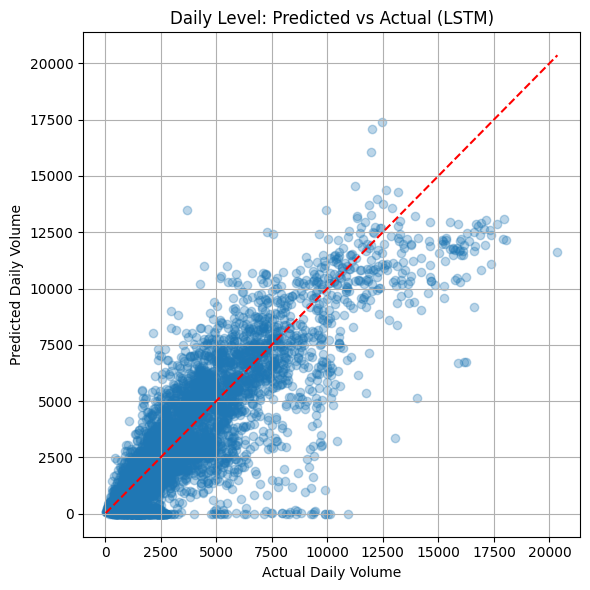

In [11]:
# Plot at the daily level
plt.figure(figsize=(6, 6))
plt.scatter(all_actuals, all_preds, alpha=0.3)
plt.plot([min(all_actuals), max(all_actuals)],
         [min(all_actuals), max(all_actuals)], 'r--')
plt.title("Daily Level: Predicted vs Actual (LSTM)")
plt.xlabel("Actual Daily Volume")
plt.ylabel("Predicted Daily Volume")
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
# --- AADB Metrics ---
aadb_df = pd.DataFrame(aadb_results, columns=['station_name', 'actual', 'predicted'])

mae_aadb = mean_absolute_error(aadb_df['actual'], aadb_df['predicted'])
rmse_aadb = np.sqrt(mean_squared_error(aadb_df['actual'], aadb_df['predicted']))
smape_aadb = smape(aadb_df['actual'], aadb_df['predicted'])

print(f"\nAADB Level Evaluation:")
print(f"MAE  : {mae_aadb:.2f}")
print(f"RMSE : {rmse_aadb:.2f}")
print(f"SMAPE: {smape_aadb:.2f}%")


AADB Level Evaluation:
MAE  : 795.73
RMSE : 1103.50
SMAPE: 38.73%


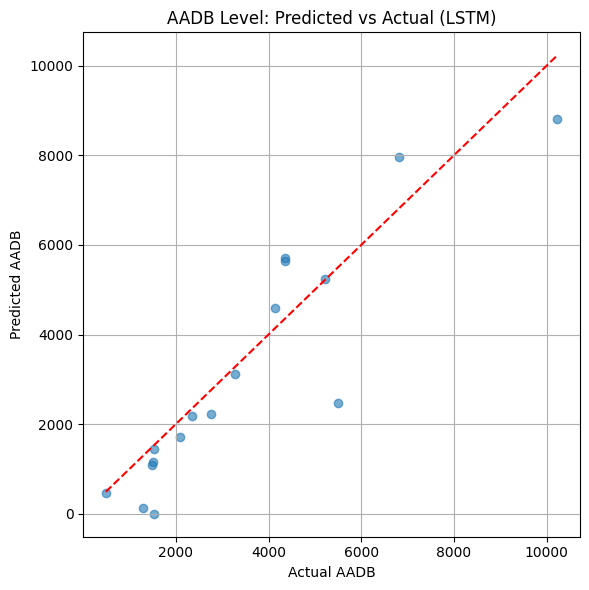

In [13]:
# Plot at the AADB level
plt.figure(figsize=(6, 6))
plt.scatter(aadb_df['actual'], aadb_df['predicted'], alpha=0.6)
plt.plot([aadb_df['actual'].min(), aadb_df['actual'].max()],
         [aadb_df['actual'].min(), aadb_df['actual'].max()], 'r--')
plt.title("AADB Level: Predicted vs Actual (LSTM)")
plt.xlabel("Actual AADB")
plt.ylabel("Predicted AADB")
plt.grid(True)
plt.tight_layout()
plt.show()